In [2]:
#!pip install pyAgrum

In [3]:
import numpy as np
import pandas as pd
import math
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

In [4]:
df = pd.read_csv("ai4i2020.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
# Renaming columns
df_renamed = df.rename(columns={'UDI': 'uid', 
                                'Product ID': 'product_id',
                                'Type': 'prod_quality',
                                'Air temperature [K]': 'air_temp',
                                'Process temperature [K]': 'process_temp',
                                'Rotational speed [rpm]': 'rot_speed',
                                'Torque [Nm]': 'torque',
                                'Tool wear [min]': 'tool_wear',
                                'Machine failure': 'machine_failure',
                                'TWF': 'tool_wear_failure',
                                'HDF': 'heat_dissipation_failure',
                                'PWF': 'power_failure',
                                'OSF': 'overstrain_failure',
                                'RNF': 'random_failure'})

In [6]:
# Power status
def calculate_power(row):
    rad_sec = (row['rot_speed'] * 2 * math.pi) / 60
    power = row['torque'] * rad_sec
    
    if power < 3500:
        power_supply_status = 'too low'
    elif power > 9000:
        power_supply_status = 'too high'
    else:
        power_supply_status = 'normal'
    return power_supply_status
    
#df_renamed['power_supply_status'] = df_renamed.apply(calculate_power, axis=1)

In [7]:
# Heat dissipation status
def heat_dissipation(row):
    heat_diff = abs(row['air_temp'] - row['process_temp'])
    
    if heat_diff < 8.6 and row['rot_speed'] < 1380:
        heat_diss_status = 'too high'
    else:
        heat_diss_status = 'normal'
    return heat_diss_status
    
#df_renamed['heat_diss_status'] = df_renamed.apply(heat_dissipation, axis=1)

In [8]:
# Drop columns
df_renamed.drop(['uid', 'product_id'],axis=1,inplace=True)

In [9]:
#pip install --upgrade --force-reinstall scikit-learn numpy scipy

In [10]:
from sklearn.model_selection import train_test_split

In [ ]:
df_renamed = df_renamed.head(200)

In [11]:
SAMPLING_PERCENTAGE = 0.1  # Adjust as needed (e.g., 0.1 for 10%, 0.5 for 50%)
RANDOM_STATE_SAMPLING = 42 # For reproducibility of sampling

In [12]:
# --- Prepare for Stratified Sampling ---
# Define the failure mode columns you want to stratify by.
# Ensure these columns are in string format before creating the combined profile.
failure_mode_columns_for_stratification = [
    'machine_failure',
    'tool_wear_failure',
    'heat_dissipation_failure',
    'power_failure',
    'overstrain_failure',
    'random_failure'
]

In [13]:

# Check if failure mode columns exist and convert them to string type if necessary
# This is crucial because train_test_split's stratify works best with categorical labels.
# If they are already 0/1 integers, converting to string is still good practice for clarity.
df_temp_for_stratify = df_renamed.copy() # Work on a copy for this step
for col in failure_mode_columns_for_stratification:
    if col not in df_temp_for_stratify.columns:
        raise ValueError(f"Column '{col}' for stratification not found in DataFrame.")
    df_temp_for_stratify[col] = df_temp_for_stratify[col].astype(str)

# Create a 'failure_profile' column for stratification
# This combines the states of all specified failure modes for each row
df_temp_for_stratify['failure_profile'] = df_temp_for_stratify[failure_mode_columns_for_stratification].agg('-'.join, axis=1)

print("\nValue counts for failure_profile (on full dataset before sampling):")
print(df_temp_for_stratify['failure_profile'].value_counts(normalize=True).head()) # Show top profiles

# --- Stratified Sampling ---
df_sampled = pd.DataFrame() # Initialize an empty DataFrame for the sample

if 0.0 < SAMPLING_PERCENTAGE < 1.0:
    print(f"\nPerforming stratified sampling to get {SAMPLING_PERCENTAGE*100}% of the data...")
    try:
        # We only need the 'train' part of the split, which will be our sample.
        # The original DataFrame df_renamed is used here, not df_temp_for_stratify,
        # to ensure we sample from the original data types, but use the 'failure_profile' from df_temp_for_stratify.
        df_sampled, _ = train_test_split(
            df_renamed, # Sample from the original df_renamed
            train_size=SAMPLING_PERCENTAGE,
            stratify=df_temp_for_stratify['failure_profile'], # Stratify using the profile from the temp df
            random_state=RANDOM_STATE_SAMPLING
        )
        print(f"Sampled dataset shape: {df_sampled.shape}")

        # Verify stratification (optional, but good for checking)
        # Re-create failure_profile on the sampled data to check distributions
        df_sampled_temp_for_check = df_sampled.copy()
        for col in failure_mode_columns_for_stratification:
             df_sampled_temp_for_check[col] = df_sampled_temp_for_check[col].astype(str)
        df_sampled_temp_for_check['failure_profile_check'] = df_sampled_temp_for_check[failure_mode_columns_for_stratification].agg('-'.join, axis=1)
        print("\nValue counts for failure_profile (on SA MPLED dataset):")
        print(df_sampled_temp_for_check['failure_profile_check'].value_counts(normalize=True).head())

    except ValueError as e:
        print(f"\nError during stratified sampling: {e}")
        print("This can happen if some strata have too few members (e.g., < 2 for classification splits).")
        print("Consider a larger SAMPLING_PERCENTAGE, different failure_mode_columns, or simpler stratification.")
        print("Falling back to random sampling without stratification for this run.")
        df_sampled = df_renamed.sample(frac=SAMPLING_PERCENTAGE, random_state=RANDOM_STATE_SAMPLING)
        print(f"Performed random sampling instead. Sampled dataset shape: {df_sampled.shape}")

elif SAMPLING_PERCENTAGE >= 1.0:
    print("\nSAMPLING_PERCENTAGE is 1.0 or greater. Using the full dataset (no sampling).")
    df_sampled = df_renamed.copy() # Use a copy to avoid modifying original df_renamed
else: # SAMPLING_PERCENTAGE is 0 or invalid
    print("\nSAMPLING_PERCENTAGE is 0 or invalid. Resulting sample will be empty or an error might occur.")
    # df_sampled remains empty or you could raise an error

# df_sampled now contains your stratified (or randomly sampled if stratification failed) data.
# You can now proceed with further preprocessing (like binning, type conversion for BN) on df_sampled.

print(f"\nFinal shape of df_sampled: {df_sampled.shape}")

# Example: Show a few rows of the sampled data
# print("\nFirst 5 rows of the sampled data (df_sampled):")
print(df_sampled.head())



Value counts for failure_profile (on full dataset before sampling):
failure_profile
0-0-0-0-0-0    0.9643
1-0-1-0-0-0    0.0106
1-0-0-1-0-0    0.0080
1-0-0-0-1-0    0.0078
1-1-0-0-0-0    0.0042
Name: proportion, dtype: float64

Performing stratified sampling to get 10.0% of the data...

Error during stratified sampling: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
This can happen if some strata have too few members (e.g., < 2 for classification splits).
Consider a larger SAMPLING_PERCENTAGE, different failure_mode_columns, or simpler stratification.
Falling back to random sampling without stratification for this run.
Performed random sampling instead. Sampled dataset shape: (1000, 12)

Final shape of df_sampled: (1000, 12)
     prod_quality  air_temp  process_temp  rot_speed  torque  tool_wear  \
6252            L     300.8         310.3       1538    36.1        198   
4684            M     303.6

In [14]:
df_renamed = df_sampled

In [15]:
# Rename columns
no_bins = 4
df_renamed['tool_wear']=pd.cut(df_renamed['tool_wear'], bins = no_bins, precision = 0)
df_renamed['air_temp']=pd.cut(df_renamed['air_temp'], bins = no_bins, precision = 0)
df_renamed['rot_speed']=pd.cut(df_renamed['rot_speed'], bins = no_bins, precision = 0)
df_renamed['torque']=pd.cut(df_renamed['torque'], bins = no_bins, precision = 0)
df_renamed['process_temp']=pd.cut(df_renamed['process_temp'], bins = no_bins, precision = 0)

In [16]:
# Transform column types
cat_list = ['prod_quality','air_temp','process_temp','rot_speed','torque', 'tool_wear']
bool_list = ['machine_failure','tool_wear_failure','heat_dissipation_failure','power_failure','overstrain_failure','random_failure']

df_renamed[cat_list] = df_renamed[cat_list].astype('category')
df_renamed[bool_list] = df_renamed[bool_list].astype('bool')
df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 6252 to 7713
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   prod_quality              1000 non-null   category
 1   air_temp                  1000 non-null   category
 2   process_temp              1000 non-null   category
 3   rot_speed                 1000 non-null   category
 4   torque                    1000 non-null   category
 5   tool_wear                 1000 non-null   category
 6   machine_failure           1000 non-null   bool    
 7   tool_wear_failure         1000 non-null   bool    
 8   heat_dissipation_failure  1000 non-null   bool    
 9   power_failure             1000 non-null   bool    
 10  overstrain_failure        1000 non-null   bool    
 11  random_failure            1000 non-null   bool    
dtypes: bool(6), category(6)
memory usage: 20.8 KB


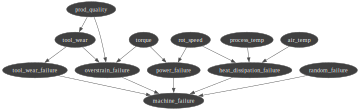

In [17]:
edge_list = 'prod_quality->tool_wear;' \
            'tool_wear->tool_wear_failure;'\
            'tool_wear_failure->machine_failure;'\
            'rot_speed->heat_dissipation_failure;'\
            'process_temp->heat_dissipation_failure;'\
            'air_temp->heat_dissipation_failure;'\
            'heat_dissipation_failure->machine_failure;'\
            'rot_speed->power_failure;'\
            'torque->power_failure;'\
            'power_failure->machine_failure;'\
            'prod_quality->overstrain_failure;'\
            'tool_wear->overstrain_failure;'\
            'torque->overstrain_failure;'\
            'overstrain_failure->machine_failure;'\
            'random_failure->machine_failure'

bn_show_relations = gum.fastBN(edge_list)

gnb.showBN(bn_show_relations)

In [18]:
# bayesian network
bn_pred_failure = gum.BayesNet("Predict_failures")

In [19]:
node_names_in_bn = set()
for arc in edge_list.split(';'):
    if '->' in arc:
        source, target = arc.split('->')
        node_names_in_bn.add(source.strip())
        node_names_in_bn.add(target.strip())

df_for_learning = df_renamed[list(node_names_in_bn)].copy()

In [20]:
for col_name in df_for_learning.columns:
    if df_for_learning[col_name].dtype.name == 'category' or df_for_learning[col_name].dtype.name == 'object':
        # For categorical (including binned-turned-string-turned-category)
        labels = sorted([str(label) for label in df_for_learning[col_name].unique()])
        # Using gum.LabelizedVariable for variables with string labels
        var = gum.LabelizedVariable(col_name, col_name, labels)
        var.setDescription(f"States: {', '.join(labels)}") # Optional: add description
    elif df_for_learning[col_name].dtype.name == 'bool':
        # For boolean variables, pyAgrum can often infer states as [0, 1] or [False, True]
        # Using LabelizedVariable for consistency and explicit label definition
        var = gum.LabelizedVariable(col_name, col_name, [str(False), str(True)])
        var.setDescription("Boolean variable (False, True)") # Optional
    else:
        raise ValueError(f"Unsupported data type for column {col_name}: {df_for_learning[col_name].dtype}")
    bn_pred_failure.add(var)

# Add arcs based on the bn_string
for arc in edge_list.split(';'):
    if '->' in arc:
        source, target = arc.split('->')
        bn_pred_failure.addArc(source.strip(), target.strip())

In [ ]:

# --- DEBUGGING STEP: Learn parameters for a SINGLE simple node first ---
# Let's pick 'tool_wear_failure' which has one parent 'tool_wear'
# This helps check if basic learning works without overwhelming memory.
single_node_to_test = 'tool_wear_failure' 
if bn_pred_failure.exists(single_node_to_test) and bn_pred_failure.parents(single_node_to_test): # Check if it has parents
    print(f"\n--- DEBUGGING: Attempting to learn CPT for single node: '{single_node_to_test}' ---")
    try:
        learner_single = gum.BNLearner(df_for_learning, bn_pred_failure) # Pass the BN so it knows about all vars/states
        learner_single.useSmoothingPrior(epsilon=1e-3)
        
        # Create a temporary DAG with only the target node and its parents
        temp_dag_single_node = gum.DAG()
        temp_dag_single_node.addNode(bn_pred_failure.idFromName(single_node_to_test))
        for parent_id in bn_pred_failure.parents(single_node_to_test):
            temp_dag_single_node.addNode(parent_id)
            temp_dag_single_node.addArc(parent_id, bn_pred_failure.idFromName(single_node_to_test))
        
        print(f"Learning parameters for the subgraph concerning '{single_node_to_test}' and its parents.")
        learner_single.learn_parameters(temp_dag_single_node) # Learn CPTs for this small part
        
        # Assign the learned CPT back to the main BN object for this node
        bn_pred_failure.cpt(single_node_to_test)[:] = learner_single.bn.cpt(single_node_to_test)[:]
        print(f"Successfully learned CPT for '{single_node_to_test}'.")
        print(bn_pred_failure.cpt(single_node_to_test))
    except Exception as e:
        print(f"ERROR during single node CPT learning for '{single_node_to_test}': {e}")
        print("If this fails, there might be issues with data for this specific node/parents or a fundamental environment problem.")
else:
    print(f"Skipping single node test for '{single_node_to_test}' as it or its parents don't exist as expected.")


In [ ]:
# --- Learning Parameters ---
print("Starting parameter learning...")
# It's crucial that df_for_learning column names and types are consistent with BN variables
learner = gum.BNLearner(df_for_learning, bn_pred_failure)
learner.learn_parameters(bn_pred_failure.dag())
print("Parameter learning completed.")

# --- Inspecting the Network (Optional) ---
print("\nCPT for 'machine_failure':")
print(bn_pred_failure.cpt('machine_failure'))

print("\nCPT for 'tool_wear_failure':")
print(bn_pred_failure.cpt('tool_wear_failure'))

# If in a Jupyter notebook, you can visualize the network with learned CPTs (optional)
print("\nShowing BN structure and CPTs (if in Jupyter):")
try:
 gnb.showBN(bn_pred_failure, size="9")
 gnb.showInformation(bn_pred_failure, size="12") # Shows CPTs as well
except Exception as e:
 print(f"Could not display BN with gnb: {e}. Ensure you are in a Jupyter environment and have graphviz installed.")

# To save the learned network:
# gum.saveBN(bn_pred_failure, "learned_predictive_failure_model.bifxml")
print("\nTo save the model, uncomment the gum.saveBN line.")